# Porto Seguro by Gabriel Preda - Third Try
이 노트북은 다음의 노트북을 참고하였습니다:
* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

## 1. Analysis packages

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

## 2. Load the data

In [52]:
trainset = pd.read_csv('../data/train.csv')
testset = pd.read_csv('../data/test.csv')

## 3. Few quick observations

대회 측의 데이터셋 설명은 다음과 같다:
* feature들은 몇 개의 group으로 나누어져 있으며, 해당 group을 표시하는 단어가 feature name에 포함되어 있다.
    * `ind`: individual-driver, `reg`: region, `car`: car-itself, `calc`: calculated
* feature name 뒤에 `bin`은 **binary feature**를 말한다.
* feature name 뒤에 `cat`은 **categorical feature**를 말한다.
* `bin`이나 `cat`이 없는 feature들은 **ordial and continuous feature**를 말한다.
* missing value는 **-1**로 표현된다.
* 예측하려면 feature는 **target**이며, *보험 청구 여부*을 나타낸다.
* `id`는 데이터를 구분하기 위한 값이다.

In [53]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [54]:
# train과 testset의 feature개수와 데이터 개수
print('trainset (rows, cols) :', trainset.shape)
print('testset (rows, cols) :', testset.shape)

trainset (rows, cols) : (595212, 59)
testset (rows, cols) : (892816, 58)


In [55]:
# testset에 없는 feature
print('columns in train and not in test dataset :',
      set(trainset.columns) - set(testset.columns))

columns in train and not in test dataset : {'target'}


## 4. Introduction of metadata
feature의 특징을 정의한 metadata를 생성한다.
* **use** : input, ID, target
* **level** : nominal, interval, ordinal, binary
* **keep** : True, False
* **dataType** : int, float, char
* **group** : ind, reg, car, calc

In [56]:
# reference : https://www.kaggle.com/bertcarremans/data-preparation-exploration
data = []
for feature in trainset.columns:
    # role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    # level
    if 'bin' in feature or feature == 'target':
        level = 'binary'
    elif 'cat' in feature or feature == 'id':
        level = 'categorical'
    elif trainset[feature].dtype == np.float64:
        level = 'real'
    elif trainset[feature].dtype == np.int64:
        level = 'integer'
    
    # keep
    keep = True
    if feature == 'id':
        keep = False
    
    # dtype
    dtype = trainset[feature].dtype
    
    # group
    group = 'none'
    if 'ind' in feature:
        group = 'individual'
    elif 'reg' in feature:
        group = 'registration'
    elif 'car' in feature:
        group = 'car'
    elif 'calc' in feature:
        group = 'calculated'
    
    # metadata dict
    feature_dict = {
        'varname': feature,
        'use': use,
        'level': level,
        'keep': keep,
        'dtype': dtype,
        'group': group
    }
    data.append(feature_dict)

In [57]:
# metadata dataframe 생성
meta = pd.DataFrame(data, columns=['varname', 'use', 'level', 'keep', 'dtype', 'group'])
meta.set_index('varname', inplace=True)
meta

,use,level,keep,dtype,group
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [58]:
# metadata 사용 예시: categorical feature
meta[(meta.level == 'categorical') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### 4.1. Features grouped by group

In [59]:
pd.DataFrame({'count': meta.groupby(['group'])['group'].size()}).reset_index()

,group,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


### 4.2. Features grouped by level and use

In [60]:
pd.DataFrame({'count': meta.groupby(['use', 'level'])[
             'use'].size()}).reset_index()

,use,level,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


## 5. Data analysis and statistics
### 5.1. Target variable

<Figure size 432x288 with 0 Axes>

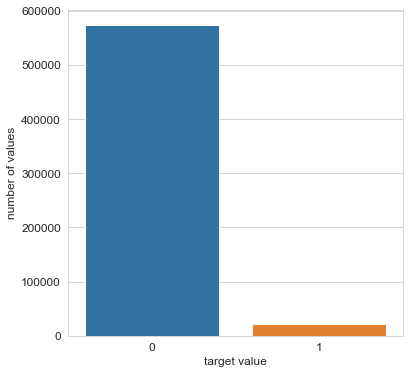

In [61]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# target value별 데이터 개수 - barplot
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('number of values', fontsize=12)
plt.xlabel('target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

`target=1`의 데이터 비율은 **3.64%**로 배우 불균형적임을 알 수 있다.

후에 `target=0`을 undersampling하거나 `target=1`을 oversampling하여 이 문제를 해결할 예정.

### 5.2. Real features

In [62]:
# real features
var = meta[(meta.level == 'real') & (meta.keep)].index
trainset[var].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


`ps_reg_03`, `ps_car_12`, `ps_car_14`의 최소값이 -1인 것으로 보아 missing value를 가지고 있음을 알 수 있다.

**registration features** 중 `ps_reg_01`과 `ps_reg_02`는 소수점이 깔끔히 떨어지는 것을 보아 0.1, 0.2와 같은 *분모가 10인 분수*임을 알 수 있다.

In [63]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [64]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

**car features** 중 `ps_car_12`는 근사적으로 (자연수x10)의 제곱근이고 `ps_car_15`도 자연수의 제곱근이다.

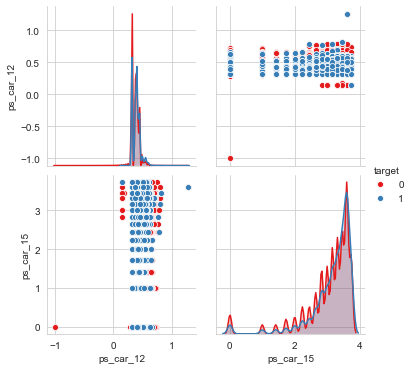

In [65]:
sample = trainset.sample(frac=0.5)    # 데이터 일부만 추출
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]

# ps_car_12와 ps_car_15, target의 관계 - pairplot
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

In [66]:
var = meta[(meta.level == 'real') & (meta.keep)].index
t1 = trainset.loc[trainset['target'] == 1]    # target=1
t0 = trainset.loc[trainset['target'] == 0]    # target=0

**calculated features**의 최대값이 모두 0.9인 것으로 보아 `ps_calc_01`, `ps_calc_02`, `ps_calc_03`은 매우 비슷한 분포를 갖고 있다고 볼 수 있다. 다른 calculated features의 최대값으로는 5, 6, 7, 10, 12가 있다.

<Figure size 432x288 with 0 Axes>

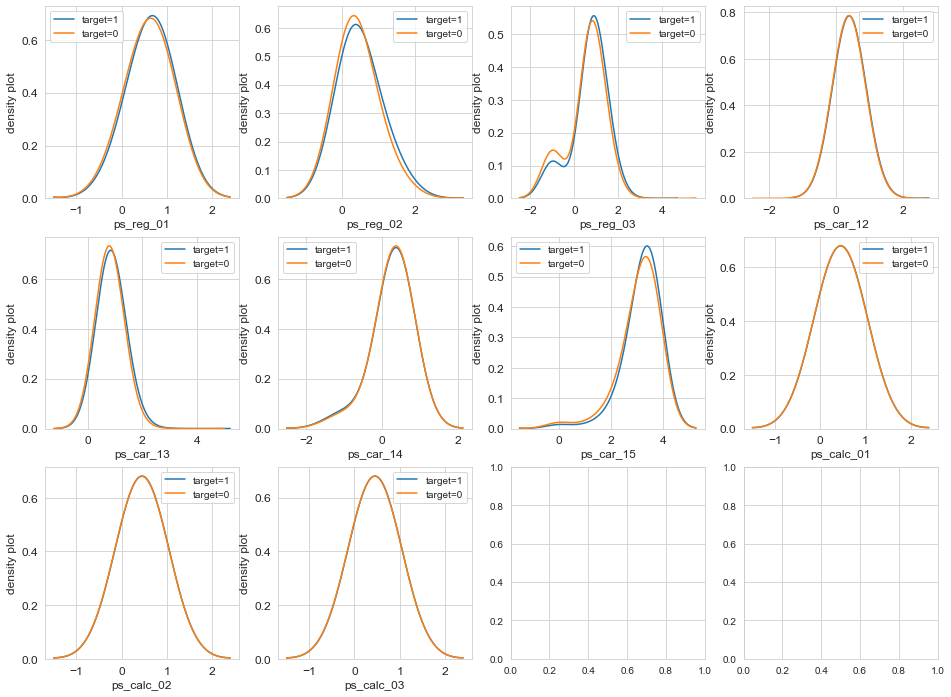

In [67]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# calculated features의 각 target value별 분포 - kdeplot
for i, feature in enumerate(var):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`ps_reg_02`, `ps_car_13`, `ps_car_15`는 *target=0*과 *target=1*일 때의 분포가 차이가 있음을 볼 수 있다.

In [68]:
# heatmap을 그리는 함수
def corr_heatmap(var):
    corrs = trainset[var].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrs, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=0.5, annot=True, cbar_kws={'shrink':.75})
    
    plt.show()

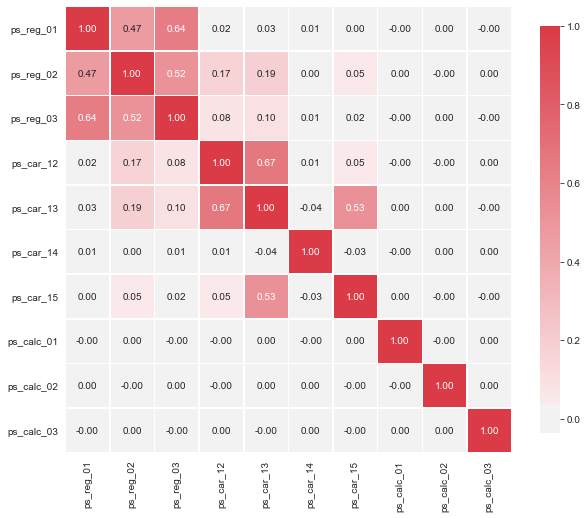

In [69]:
# real feature들의 상관관계 - heatmap
var = meta[(meta.level == 'real') & (meta.keep)].index
corr_heatmap(var)

다음의 calculated feature의 쌍들은 **강한 상관관계**를 보인다.
* `ps_reg_01`과 `ps_reg_02` : 0.47
* `ps_reg_01`과 `ps_reg_03` : 0.64
* `ps_reg_02`과 `ps_reg_03` : 0.52
* `ps_car_12`와 `ps_car_13` : 0.67
* `ps_car_13`와 `ps_car_15` : 0.53

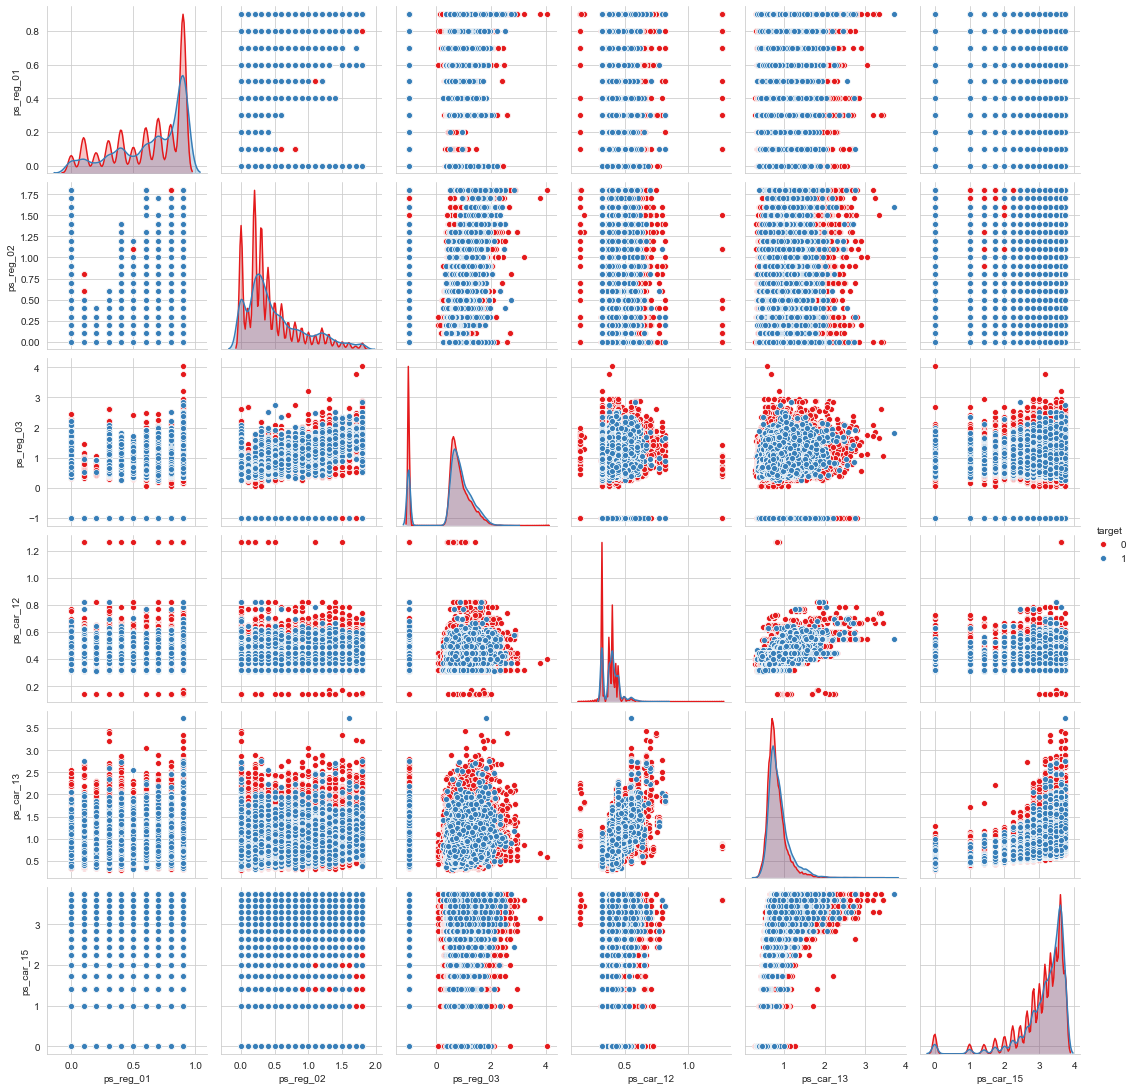

In [70]:
sample = trainset.sample(frac=0.5)    # 일부 데이터만 추출
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]

# 상관관계가 높은 real feature들의 관계 - pairplot
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### 5.3. Binary features

In [71]:
# binary features
var = meta[(meta.level == 'binary') & (meta.keep)].index
trainset[var].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [72]:
# target을 제외한 binary features
var = meta[(meta.level == 'binary') & (meta.use == 'input') & (meta.keep)].index
# 0과 1의 비율을 저장
zero_list, one_list = list(), list()

for feature in var:
    zero_list.append((trainset[feature] == 0).sum() / trainset.shape[0] * 100)
    one_list.append((trainset[feature] == 1).sum() / trainset.shape[0] * 100)

<Figure size 432x288 with 0 Axes>

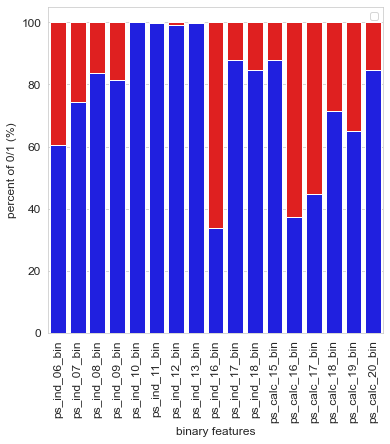

In [73]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# binary feature의 0과 1의 비율 - barplot
p1 = sns.barplot(ax=ax, x=list(var), y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=list(var), y=one_list, bottom=zero_list, color='red')
plt.ylabel('percent of 0/1 (%)', fontsize=12)
plt.xlabel('binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('zero', 'one'))
plt.show()

`ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin`의 1의 비율은 **0.5%**가 안 될 정도로 매우 작고, `ps_ind_16_bin`, `ps_calc_16_bin`은 1의 비율이 **60%**가 넘는다.

In [74]:
# binary features
var = meta[(meta.level == 'binary') & (
    meta.use == 'input') & (meta.keep)].index
t1 = trainset.loc[trainset['target'] == 1]    # target=1
t0 = trainset.loc[trainset['target'] == 0]    # target=0

<Figure size 432x288 with 0 Axes>

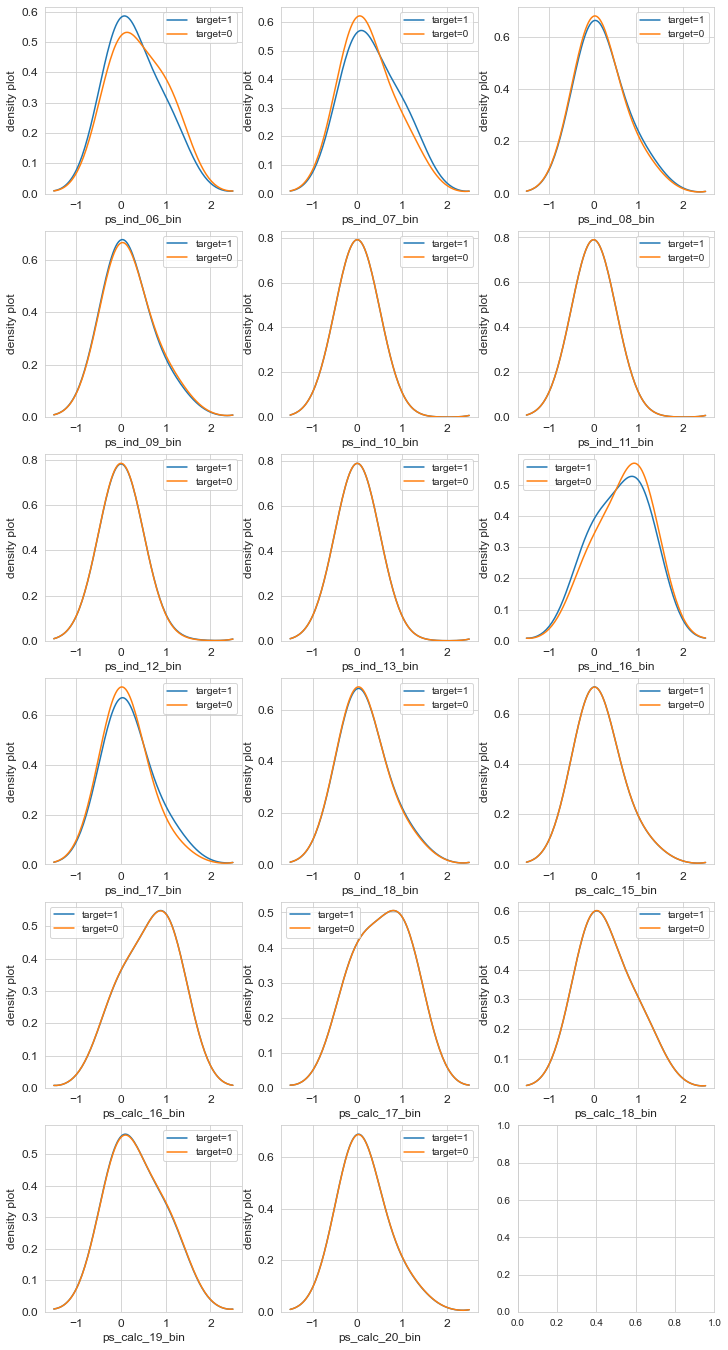

In [75]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

# target에 따른 binary feature의 분포 - kdeplot
for i, feature in enumerate(var):
    plt.subplot(6, 3, i+1)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`ps_ind_06_bin`, `ps_ind_07_bin`, `ps_ind_16_bin`, `ps_ind_17_bin`는 0과 1일 때의 분포가 꽤 다른 것을 볼 수 있다. 또한 매우 비슷한 분포를 가진 다른 feature에 비해 `ps_ind_08_bin`도 0과 1일 때의 분포가 다소 다른 것을 볼 수 있다.

### 5.4. Categorical features

In [76]:
# categorical features
var = meta[(meta.level == 'categorical') & (meta.keep)].index

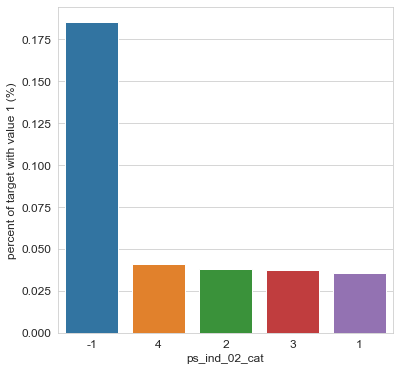

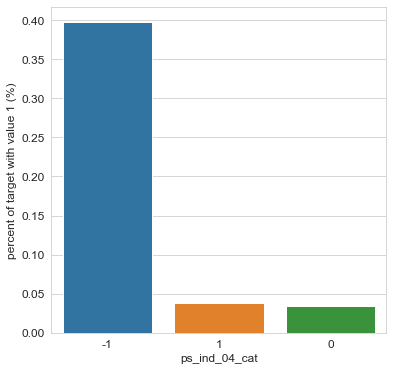

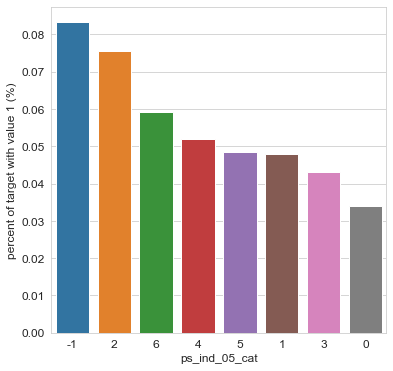

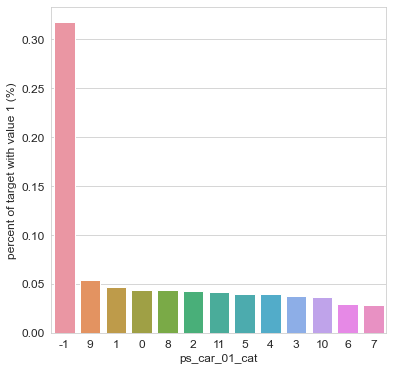

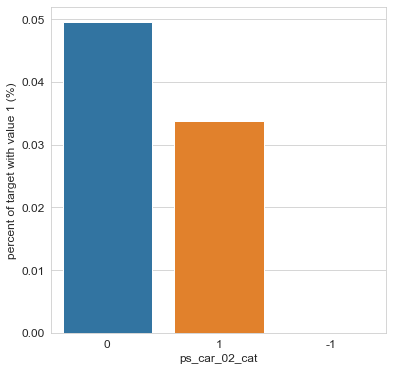

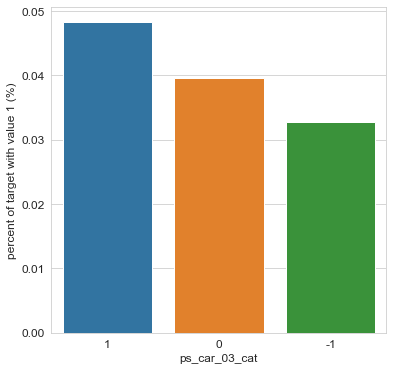

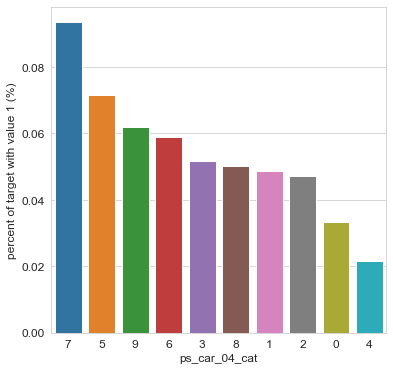

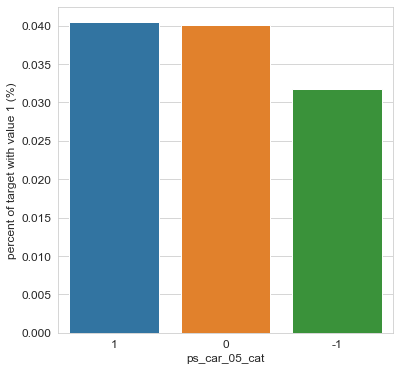

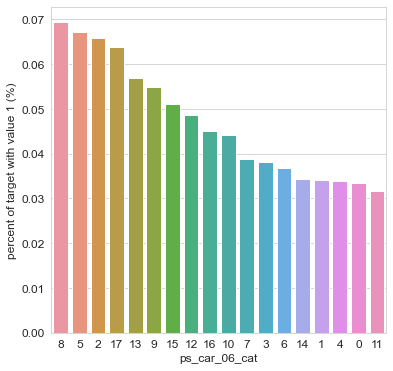

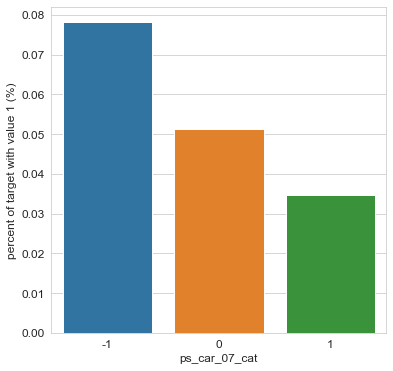

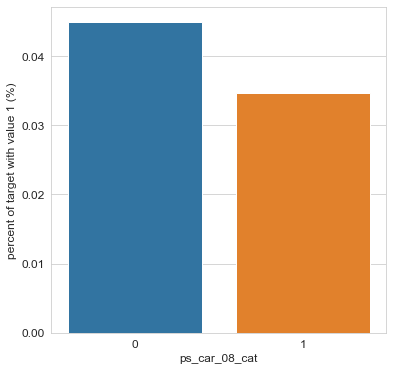

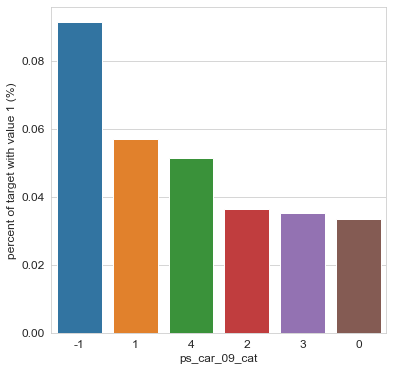

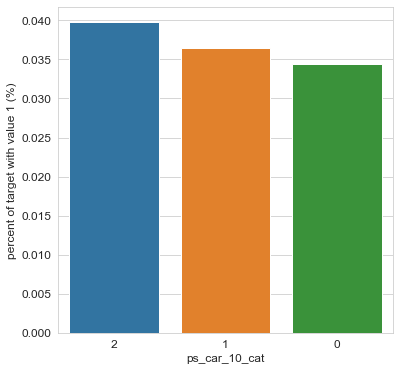

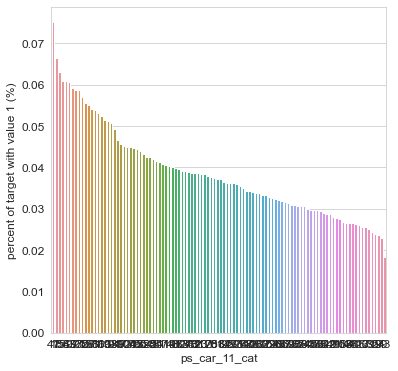

In [77]:
# 분포 표현 방법 1. barplot
for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))

    # category의 value별 target=1의 비율
    cat_perc = trainset[[feature, 'target']].groupby(
        [feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    # target의 평균값을 기준으로 역 정렬
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('percent of target with value 1 (%)', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

<Figure size 432x288 with 0 Axes>

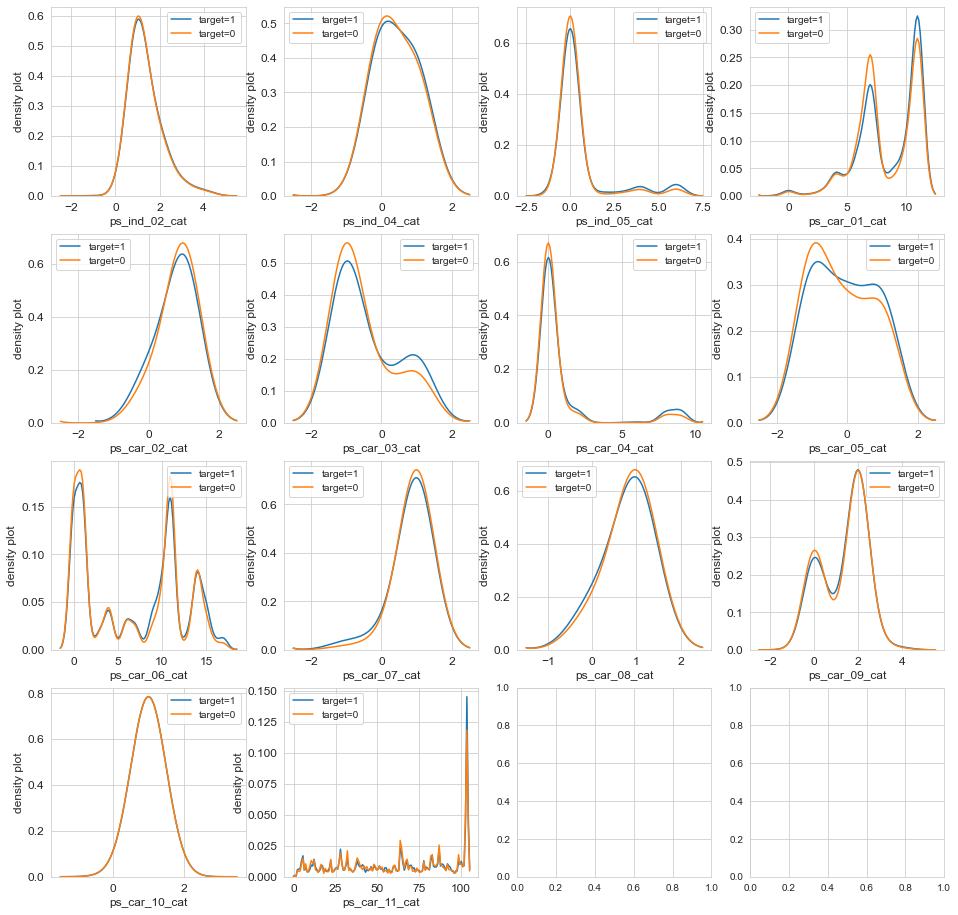

In [78]:
# 분포 표현 방법 2. kdeplot
t1 = trainset.loc[trainset['target'] == 1]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i, feature in enumerate(var):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    
plt.show()

`ps_car_03_cat`, `ps_car_05_cat`은 target=0과 target=1에 따른 value의 분포 차이가 가장 큰 것을 볼 수 있다.

## 6. Data unbalance between train and test data
앞서 봤던 것처럼 `target`의 value는 매우 불균형한 것을 볼 수 있다. 이것을 해결하기에 앞서서 *trainset과 testset의 feature들의 분포*를 살펴보자.

### 6.1. Registration features

<Figure size 432x288 with 0 Axes>

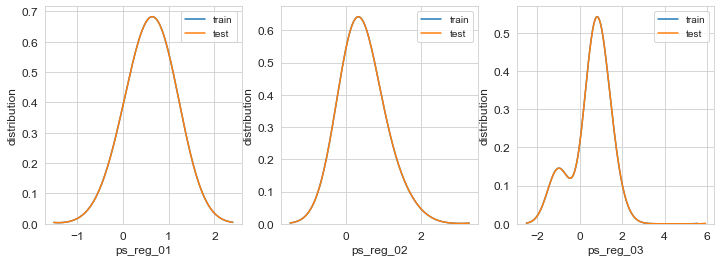

In [79]:
# registration features
var = meta[(meta.group == 'registration') & (meta.keep)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, feature in enumerate(var):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

**reg features**는 trainset과 testset의 분포 모두 균형적임을 볼 수 있다.

### 6.2. Car features

<Figure size 432x288 with 0 Axes>

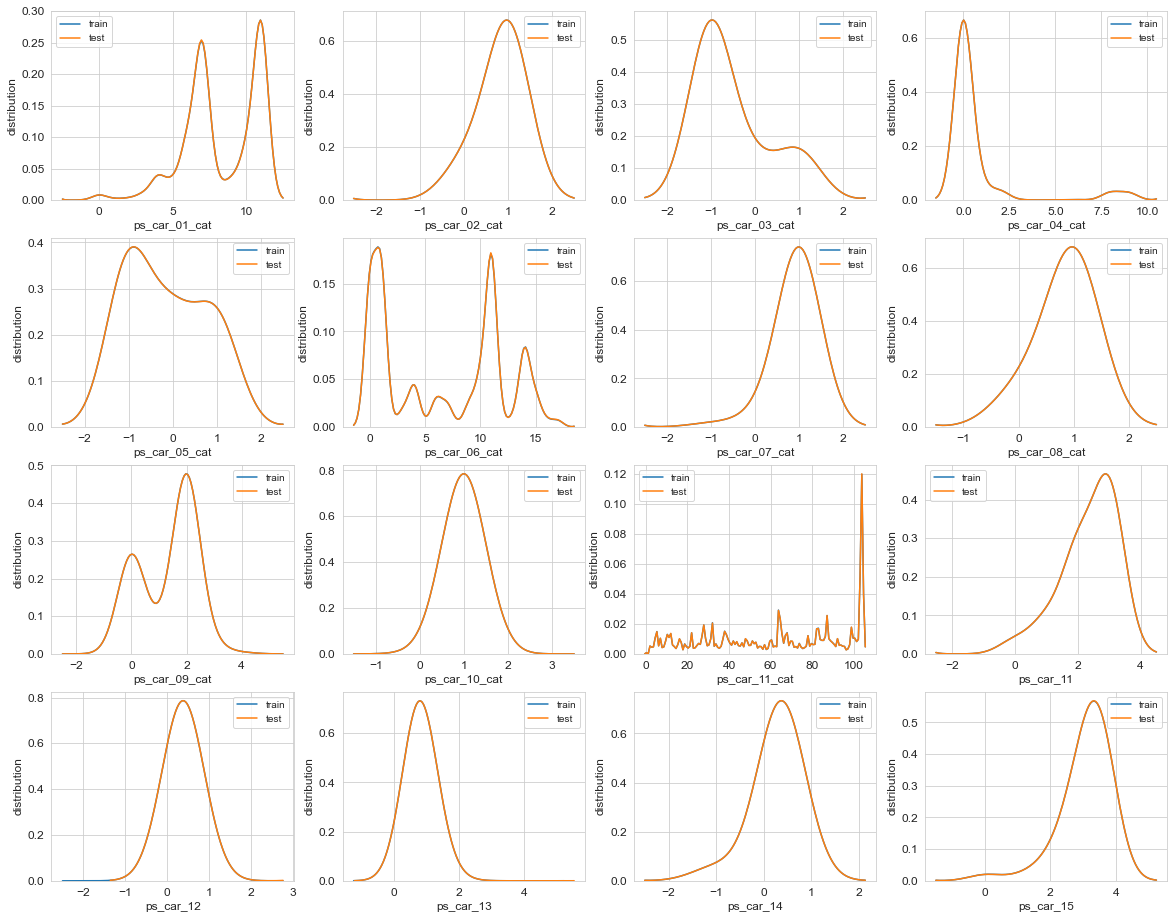

In [80]:
# car features
var = meta[(meta.group == 'car') & (meta.keep)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))

for i, feature in enumerate(var):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

**car features**도 trainset과 testset 모두 균형적임을 볼 수 있다.

### 6.3. Individual features

<Figure size 432x288 with 0 Axes>

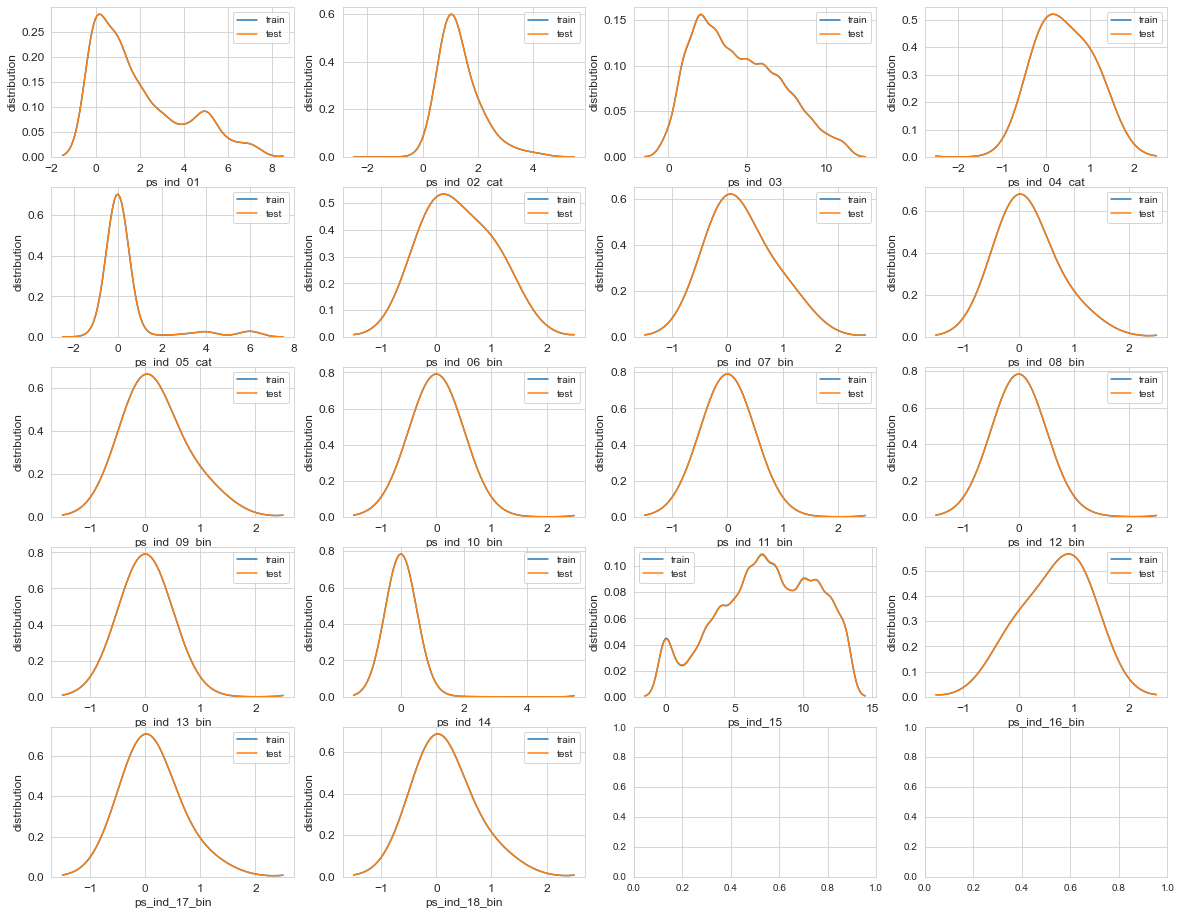

In [81]:
# individual features
var = meta[(meta.group == 'individual') & (meta.keep)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))

for i, feature in enumerate(var):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

**individual feature**도 trainset과 testset 모두 균형적이다.

### 6.4. Calc features

<Figure size 432x288 with 0 Axes>

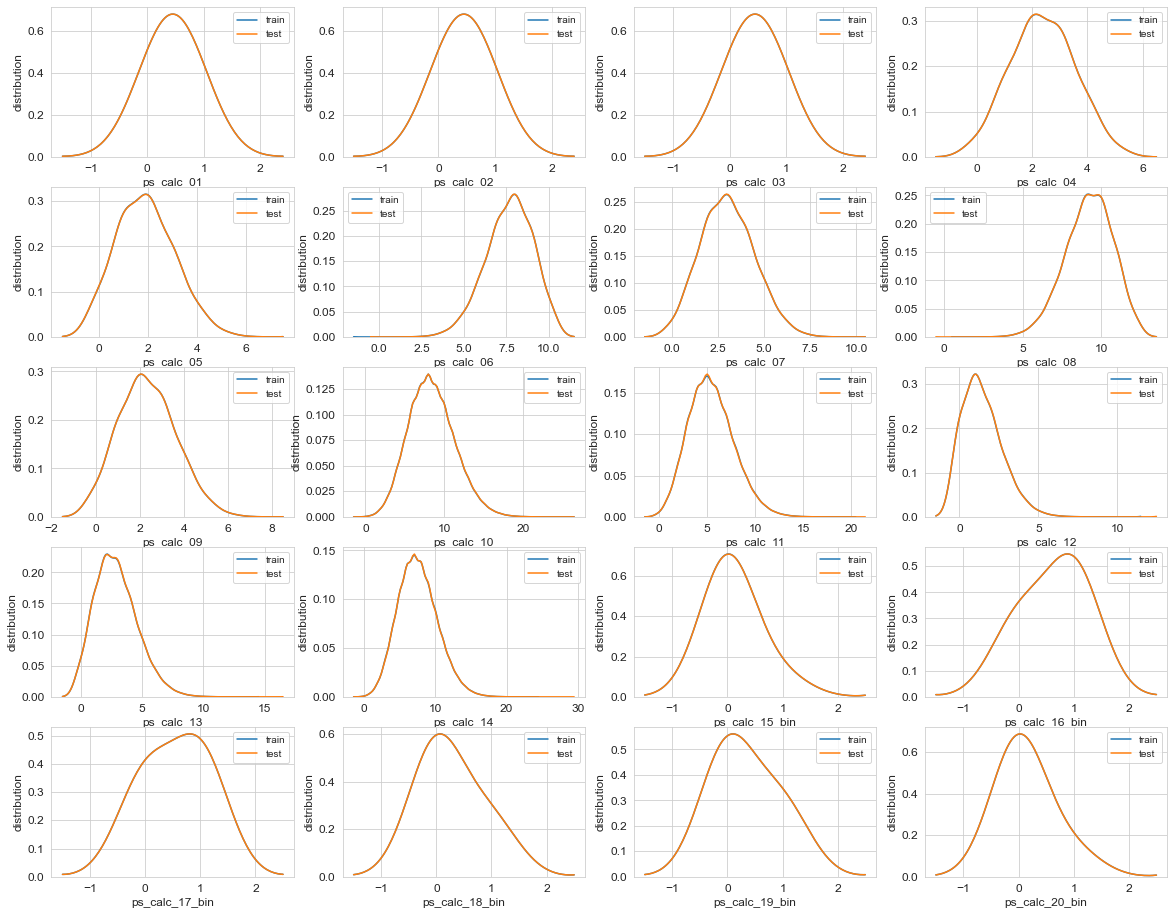

In [82]:
# calculated features
var = meta[(meta.group == 'calculated') & (meta.keep)].index

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))

for i, feature in enumerate(var):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

**calc feature**도 trainset과 testset 모두 균형적임을 볼 수 있다.

[Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction](https://www.youtube.com/watch?v=mbxZ_zqHV9c)의 `6:30`부터의 feature elimination에 따르면 **calc features**는 임의로 생성된 수로 이루어진 feature라고 한다. 아마도 대회 측에서 *대회 참여자들은 테스트하기 위해 임의로 넣어둔 것*이라고 추측 중. 결국 아무 쓸모도 없기에 후에 해당 feature는 제거할 예정이다.

## 7. Check data quality
각 feature의 missing value의 비율을 살펴보자.

In [83]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]

        print('variable {} has {} records ({:.2%}) with missing values.'.format(
            feature, missings, missings_perc))

print('In total, there are {} variables with missing values.'.format(
    len(vars_with_missing)))

variable ps_ind_02_cat has 216 records (0.04%) with missing values.
variable ps_ind_04_cat has 83 records (0.01%) with missing values.
variable ps_ind_05_cat has 5809 records (0.98%) with missing values.
variable ps_reg_03 has 107772 records (18.11%) with missing values.
variable ps_car_01_cat has 107 records (0.02%) with missing values.
variable ps_car_02_cat has 5 records (0.00%) with missing values.
variable ps_car_03_cat has 411231 records (69.09%) with missing values.
variable ps_car_05_cat has 266551 records (44.78%) with missing values.
variable ps_car_07_cat has 11489 records (1.93%) with missing values.
variable ps_car_09_cat has 569 records (0.10%) with missing values.
variable ps_car_11 has 5 records (0.00%) with missing values.
variable ps_car_12 has 1 records (0.00%) with missing values.
variable ps_car_14 has 42620 records (7.16%) with missing values.
In total, there are 13 variables with missing values.


## 8. Prepare the data from model
### 8.1. Drop calc features
앞서 말한 것처럼 쓸모가 없는 **calc features**를 제거한다.

In [84]:
# calc feature 제거
vars_to_drop = meta[(meta.group == 'calculated') & (meta.keep)].index

trainset = trainset.drop(vars_to_drop, axis=1)
testset = testset.drop(vars_to_drop, axis=1)

### 8.2. Drop variables with too many missing values
missing value가 많은 `ps_car_03_cat`과 `ps_car_05_cat`을 제거한다.

In [85]:
# missing value가 많은 feature의 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']

trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)

# metadata 업데이트
meta.loc[(vars_to_drop), 'keep'] = False

### 8.3. Replace ps_car_11_cat_encoded value
`target_encode()` 함수를 사용하여 trainset과 testset의 `ps_car_11_cat`을 encoding한다. 

이 `ps_car_11_cat`의 경우 categorical unique value가 많아 dummy features를 만들기 어려운 feature이다. 그래서 [이 논문](http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf)을 참고하여 다음과 같은 encoding 함수를 구현하였다.

In [86]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """
    # 최소 실행 조건 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # target 평균값 계산
    averages = temp.groupby(by=trn_series.name)[
        target.name].agg(["mean", "count"])
    
    # smoothing 계산
    smoothing = 1 / \
        (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # target data의 평균을 계산
    prior = target.mean()
    
    # 개수가 많을 수록 full_avg가 덜 고려됨
    averages[target.name] = prior * \
        (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # averages를 trn_series와 tst_series에 적용
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(
            columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(
            columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    
    # pd.merge는 인덱스를 갖지 않으므로 복구
    ft_trn_series.index = trn_series.index
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [87]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"],
                                            testset["ps_car_11_cat"],
                                            target=trainset.target,
                                            min_samples_leaf=100,
                                            smoothing=10,
                                            noise_level=0.01)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat', 'keep'] = False  # metadata 업데이트
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### 8.4. Balance target variable
`target=0`을 undersampling하여 `target=0`과 `target=1`의 균형을 맞춰준다.

In [88]:
desired_apriori = 0.10

# target value별 index
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# target value별 데이터 개수
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# undersampling rate, target=0의 최종 데이터 개수 계산
undersampling_rate = ((1 - desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('rate to undersample records with target=0 : {}'.format(undersampling_rate))
print('number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

# target=0의 데이터 중 10%만 임의로 추출
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# 남은 index랑 붙여줌
idx_list = list(undersampled_idx) + list(idx_1)

# undersampled dataframe으로 교체
trainset = trainset.loc[idx_list].reset_index(drop=True)

rate to undersample records with target=0 : 0.34043569687437886
number of records with target=0 after undersampling : 195246


### 8.5. Replace -1 values with NaN
편의를 위해 -1을 NaN으로 바꿔준다.

In [89]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### 8.6. Dummify cat values
categorical feature의 dummy features를 생성한다.

In [90]:
var = meta[(meta.level == 'categorical') & (
    meta.use == 'input') & (meta.keep)].index

# trainset과 testset의 categorical feature encoding
trainset = pd.get_dummies(trainset, columns=var, drop_first=True)
testset = pd.get_dummies(testset, columns=var, drop_first=True)

### 8.7. Drop unused and target features
`id`와 `target` feature를 분리한다.

In [91]:
target_train = trainset['target'].values
id_test = testset['id'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

### 8.8. Result of feature engineering
feature engineering이 잘 적용되었는지 trainset과 testset의 크기를 확인해보자.

In [92]:
print('train dataset (rows, cols) :', trainset.values.shape)
print('test dataset (rows, cols) :', testset.values.shape)

train dataset (rows, cols) : (216940, 80)
test dataset (rows, cols) : (892816, 80)


## 9. Prepare the model
### 9.1. Ensemble class for cross validation
교차검증(cross validation)과 앙상블(ensemble)을 위한 `Emsemble` 클래스를 구현한다.

In [93]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)  # trainset의 feature 개수
        y = np.array(y)  # trainset의 데이터 개수
        T = np.array(T)  # testset의 feature 개수

        # n_splits만큼 데이터를 분리
        folds = list(StratifiedKFold(n_splits=self.n_splits,
                                     shuffle=True, random_state=314).split(X, y))
        
        # 각 basemodel별 예측결과를 저장
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            # 각 fold마다 base model을 학습
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print("Base model %d: fit %s model | fold %d" %
                      (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)    # 학습
                # Kfold 교차검증
                cross_score = cross_val_score(
                    clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" %
                      (cross_score.mean(), 2*cross_score.mean()-1))
                
                # 학습된 base model 검증
                y_pred = clf.predict_proba(X_holdout)[:, 1]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:, 1]
            
            S_test[:, i] = S_test_i.mean(axis=1)
        
        # stacking
        results = cross_val_score(
            self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # gini factor = 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))
        
        # 최종 모델로 예측
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:, 1]
        
        return res

### 9.2. Parameters for the base models
base model로 3개의 `LightGBM`과 1개의 `XGBoost` model을 사용한다.

* LightGBM Parameter : https://lightgbm.readthedocs.io/en/latest/Parameters.html
* XGBoost Parameter : https://xgboost.readthedocs.io/en/latest/parameter.html

In [94]:
# LightGBM parameters
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02      # 학습률
lgb_params1['n_estimators'] = 650        # 반복 수행하려는 트리의 개수
lgb_params1['max_bin'] = 10 
lgb_params1['subsample'] = 0.8 
lgb_params1['subsample_freq'] = 10 
lgb_params1['colsample_bytree'] = 0.8 
lgb_params1['min_child_samples'] = 500 
lgb_params1['seed'] = 314 
lgb_params1['num_threads'] = 4

In [95]:
#lgb_2
lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02 
lgb_params2['n_estimators'] = 1090
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['colsample_bytree'] = 0.3
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314 
lgb_params2['num_threads'] = 4

In [96]:
#lgb_3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02 
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

In [97]:
# xgboost parameters
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

### 9.3. Initialize the models with the parameters

In [100]:
# base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# stacking model
log_model = LogisticRegression()

### 9.4. Initialize the ensemble object

In [101]:
stack = Ensemble(n_splits=3, stacker=log_model, base_models=(
    lgb_model1, lgb_model2, lgb_model3, xgb_model))

## 10. Run the predictive models

In [102]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63691 [gini]: 0.27382
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63864 [gini]: 0.27729
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63510 [gini]: 0.27021
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63885 [gini]: 0.27770
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63897 [gini]: 0.27795
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63660 [gini]: 0.27320
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63621 [gini]: 0.27243
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63582 [gini]: 0.27165
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63380 [gini]: 0.26761
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63839 [gini]: 0.27678
Base model 4: fit XGBClassifier model | fold 2
cros

## 11. Prepare the submission

In [103]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('../data/submission3.csv', index=False)